In [5]:
# install the open cv library
!pip install opencv-python

     --------------------------------------- 38.2/38.2 MB 31.2 MB/s eta 0:00:00


In [21]:
# importing the packages
import pandas as pd
import os
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [47]:
# change these variables according to your file settings
# setting the dataset path
# dataset_path = "../datasets/"
# twitter_gan_folder = "TwitterGAN/"
# random_twitter_folder = "25k_random_twitter_images/"
ffhq_dataset = "../../ffhq_dataset/"
style_gan_folder = "../../styleGAN_25k/"

## Getting the FFHQ dataset list

In [48]:
# twitter faces test_set
ffhq_faces_list = os.listdir(f"{ffhq_dataset}")
f"There are {len(ffhq_faces_list)} images present which are identified as GAN faces"

'There are 52001 images present which are identified as GAN faces'

In [50]:
# random twitter profile pictures
style_gan_images_list = os.listdir(f"{style_gan_folder}")
f"There are {len(style_gan_images_list)} images present"

'There are 16687 images present'

## Our aim is to detect open and closed eyes, along with nose and lips.

We are using 2 different cascades for eye detection
<br>
1 for nose detection
<br>
1 for lips detection
<br>
Reference https://stackoverflow.com/questions/48905775/difference-betweeen-haarcascade-eye-and-haarcascade-eye-tree-eyeglasses-xml
https://stackoverflow.com/questions/20801015/recommended-values-for-opencv-detectmultiscale-parameters

In [51]:
# read the face and eye cascade values
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
feature_cascade = cv2.CascadeClassifier('haarcascade_lefteye_2splits.xml')

## Extracting features from Twitter GAN dataset

In [171]:
# eye center formula = (x + int(w/2), y + int(h/2))

positive_feature_count = 0
negative_feature_count = 0

features_list = []
experiments_list = []

# conducting experiment for min_neighbors = 2 to 10 and increasing the sf by 5%
for min_neighbors in tqdm(range(2, 11)):
    # reinitializing the scale_factor
    scale_factor = 1.00
    
    while scale_factor <= 1.2:
        # incrementing the scale_factor
        scale_factor += 0.01
        
        # reinitializing the count metrics
        positive_feature_count = 0
        negative_feature_count = 0
        features_list = []
                
        # extracting the faces and eye coordinates
        for file_path in twitter_gan_faces_list:
            img = cv2.imread(f"{dataset_path + twitter_gan_folder + file_path}", cv2.IMREAD_GRAYSCALE) 

            # resizing the image to same dimension
            img = cv2.resize(img, (200, 200))

            # detect for face
            face_rect = face_cascade.detectMultiScale(img, scaleFactor=1.05, minNeighbors=5)

            # front face found
            if len(face_rect) != 0:
                # detect features
                feature_rect = feature_cascade.detectMultiScale(img, scaleFactor=scale_factor, minNeighbors=min_neighbors)   

                # features found
                if len(feature_rect) != 0:
                    for (x, y, w, h) in eye_rect:
                        # appending the coordinate
                        features_list.append([file_path, x + int(w/2), y + int(h/2)])

                        # increment the left eye positive count
                        positive_feature_count += 1
                else:
                    # increment the negative count
                    negative_feature_count += 1
        
        # creating a df for x and y features
        df = pd.DataFrame(features_list, columns=['file_name', 'feature_x', 'feature_y'])
        file_name = f"facial_features_{scale_factor}_{min_neighbors}_features.csv"
        df.to_csv(f"./results/{file_name}")
        df.drop(df.index , inplace=True)

        experiments_list.append([scale_factor, min_neighbors, positive_feature_count, negative_feature_count, file_name])

f"done with the processing of data...."

100%|████████████████████████████████████████████| 9/9 [46:11<00:00, 307.91s/it]


'done with the processing of data....'

## FFHQ Dataset Generation
Generation of feature coordinates for FFHQ dataset 

In [60]:
# reinitializing the count metrics
experiments_list = []
positive_feature_count = 0
negative_feature_count = 0
features_list = []

# extracting the faces and eye coordinates
for file_path in tqdm(range(len(ffhq_faces_list))):
    img = cv2.imread(f"{ffhq_dataset + ffhq_faces_list[file_path]}", cv2.IMREAD_GRAYSCALE) 

    # resizing the image to same dimension
    img = cv2.resize(img, (200, 200))

    # detect for face
    face_rect = face_cascade.detectMultiScale(img, scaleFactor=1.05, minNeighbors=5)

    # front face found
    if len(face_rect) != 0:
        # detect features
        feature_rect = feature_cascade.detectMultiScale(img, scaleFactor=1.01, minNeighbors=3)   

        # features found
        if len(feature_rect) != 0:
            for (x, y, w, h) in feature_rect:
                # appending the coordinate
                features_list.append([ffhq_faces_list[file_path], x + int(w/2), y + int(h/2), "No"])

                # increment the left eye positive count
                positive_feature_count += 1
        else:
            # increment the negative count
            negative_feature_count += 1

# creating a df for x and y features
df = pd.DataFrame(features_list, columns=['file_name', 'feature_x', 'feature_y', "is_gan"])
file_name = f"facial_features_true.csv"
df.to_csv(f"{file_name}")
df.drop(df.index , inplace=True)

experiments_list.append([1.01, 3, positive_feature_count, negative_feature_count, file_name])

100%|██████████| 52001/52001 [1:15:02<00:00, 11.55it/s]


## StyleGAN dataset generation
Generation of feature coordinates for StyleGAN dataset

In [61]:
# reinitializing the count metrics
# experiments_list = []
positive_feature_count = 0
negative_feature_count = 0
features_list = []

# extracting the faces and eye coordinates
for file_path in tqdm(range(len(style_gan_images_list))):
    img = cv2.imread(f"{style_gan_folder + style_gan_images_list[file_path]}", cv2.IMREAD_GRAYSCALE) 
        
    if img is None:
        continue
    
    # resizing the image to same dimension
    img = cv2.resize(img, (200, 200))

    # detect for face
    face_rect = face_cascade.detectMultiScale(img, scaleFactor=1.05, minNeighbors=5)

    # front face found
    if len(face_rect) != 0:
        # detect features
        feature_rect = feature_cascade.detectMultiScale(img, scaleFactor=1.01, minNeighbors=3)   

        # features found
        if len(feature_rect) != 0:
            for (x, y, w, h) in feature_rect:
                # appending the coordinate
                features_list.append([style_gan_images_list[file_path], x + int(w/2), y + int(h/2), "Yes"])

                # increment the left eye positive count
                positive_feature_count += 1
        else:
            # increment the negative count
            negative_feature_count += 1
            
# creating a df for x and y features
df = pd.DataFrame(features_list, columns=['file_name', 'feature_x', 'feature_y', "is_gan"])
file_name = f"facial_features_false.csv"
df.to_csv(f"{file_name}")
df.drop(df.index , inplace=True)

experiments_list.append([1.01, 3, positive_feature_count, negative_feature_count, file_name])

100%|██████████| 16687/16687 [29:23<00:00,  9.46it/s]


## Plotting the experiments results

In [63]:
df = pd.DataFrame(experiments_list, columns=['scale_factor', 'min_neighbors', 'positive_feature_count', 'negative_feature_count', 'file_name'])
df.to_csv("experiments_results.csv")

In [174]:
experiments_df = pd.read_csv("experiments_csv")

In [175]:
experiments_df = experiments_df.drop(columns=['Unnamed: 0'])

In [176]:
experiments_df.head()

,scale_factor,min_neighbors,positive_feature_count,negative_feature_count,file_name
0,1.01,2,1088,0,facial_features_1.01_2_features.csv
1,1.02,2,1084,1,facial_features_1.02_2_features.csv
2,1.03,2,1084,1,facial_features_1.03_2_features.csv
3,1.04,2,1076,3,facial_features_1.04_2_features.csv
4,1.05,2,1076,3,facial_features_1.05_2_features.csv


<AxesSubplot:xlabel='scale_factor', ylabel='positive_feature_count'>

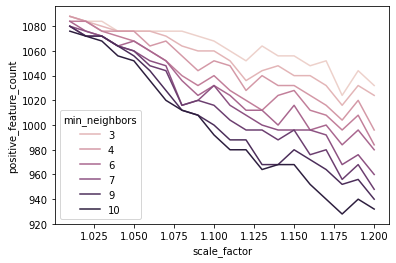

In [179]:
sns.lineplot(data=experiments_df, x=experiments_df["scale_factor"], y=experiments_df["positive_feature_count"], hue=experiments_df["min_neighbors"])

In [181]:
max(experiments_df["positive_feature_count"])

1088

In [182]:
experiments_df.query('positive_feature_count == positive_feature_count.max()')

,scale_factor,min_neighbors,positive_feature_count,negative_feature_count,file_name
0,1.01,2,1088,0,facial_features_1.01_2_features.csv
20,1.01,3,1088,0,facial_features_1.01_3_features.csv
40,1.01,4,1088,0,facial_features_1.01_4_features.csv


## Performing EDA on TwitterGAN dataset

In [185]:
facial_features_df = pd.read_csv("facial_features_1.01_2_features.csv")

In [186]:
facial_features_df.head()

,Unnamed: 0,file_name,feature_x,feature_y
0,0,twitter_GAN_profiles_1673898489_16132647404652...,73,93
1,1,twitter_GAN_profiles_1673898489_16132647404652...,122,93
2,2,twitter_GAN_profiles_1673898489_16132647404652...,93,119
3,3,twitter_GAN_profiles_1673898489_16132647404652...,96,141
4,4,twitter_GAN_profiles_1675459188_14972759585118...,73,93


In [188]:
facial_features_df = facial_features_df.drop(["Unnamed: 0"], axis=1)

In [205]:
facial_features_df.shape
set_s = set()

for i in range(len(facial_features_df)):
    set_s.add((facial_features_df["feature_x"][i], facial_features_df["feature_y"][i]))
set_s

{(73, 93), (93, 119), (96, 141), (122, 93)}

<AxesSubplot:xlabel='feature_x', ylabel='feature_y'>

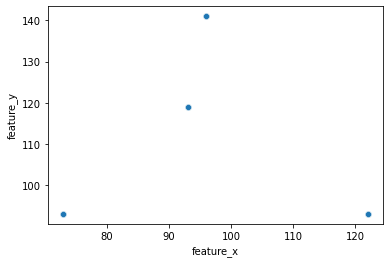

In [194]:
sns.scatterplot(data=facial_features_df, x="feature_x", y="feature_y")

## Plotting the scatter plot of true and false images

In [64]:
# reading the csv
features_dataframe = pd.read_csv("final data features.csv")

In [65]:
features_dataframe.head()

,file_name,feature_x,feature_y,is_gan
0,00000.png,125,89,No
1,00000.png,101,130,No
2,00000.png,73,87,No
3,00001.png,126,91,No
4,00001.png,76,139,No


C:\Users\srmhalgi\AppData\Local\Temp\ipykernel_13964\1940337751.py:1: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.scatterplot(data=features_dataframe,


<Axes: xlabel='feature_x', ylabel='feature_y'>

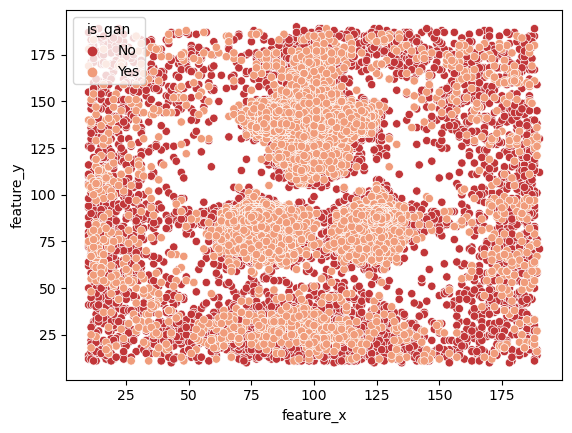

In [86]:
sns.scatterplot(data=features_dataframe, 
                x=features_dataframe["feature_x"], 
                y=features_dataframe["feature_y"], 
                hue=features_dataframe["is_gan"],
                palette = sns.color_palette("RdBu"))